In [26]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from typing import List


# Task 1: Acquire the data

In [27]:
import pandas as pd
import torch

df_train = pd.read_csv('./sign_mnist_train.csv')
df_test = pd.read_csv("./sign_mnist_test.csv")

X_train, y_train = df_train.iloc[:,1:].values/255.0, df_train.iloc[:,0].values #normalizing takes place here
X_test, y_test = df_test.iloc[:,1:].values/255.0, df_test.iloc[:,0].values

value_counts = {value: np.count_nonzero(y_train == value) for value in range(-1, 31)}

print(value_counts)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #One hot encoding of the labels
# y_train = lb.fit_transform(y_train)
# y_test = lb.fit_transform(y_test)

print("X_train numpy shape: "+ str(X_train.shape))
print("X_test numpy shape: " +str(X_test.shape))
print("y_train numpy shape: " +str(y_train.shape))
print("y_test numpy shape: " + str(y_test.shape))


X_train_tensor, y_train_tensor = torch.tensor(X_train, dtype=torch.float).reshape(-1, 1, 28, 28), torch.tensor(y_train, dtype=torch.long) #Reshaped to 2D images for the CNN
X_test_tensor, y_test_tensor = torch.tensor(X_test, dtype=torch.float).reshape(-1,1,28,28), torch.tensor(y_test, dtype=torch.long)

print("X_train tensor shape: "+ str(X_train_tensor.shape))
print("X_test tensor shape: " +str(X_test_tensor.shape))
print("y_train tensor shape: " +str(y_train_tensor.shape))
print("y_test tensor shape: " + str(y_test_tensor.shape))


{-1: 0, 0: 1126, 1: 1010, 2: 1144, 3: 1196, 4: 957, 5: 1204, 6: 1090, 7: 1013, 8: 1162, 9: 0, 10: 1114, 11: 1241, 12: 1055, 13: 1151, 14: 1196, 15: 1088, 16: 1279, 17: 1294, 18: 1199, 19: 1186, 20: 1161, 21: 1082, 22: 1225, 23: 1164, 24: 1118, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0}
X_train numpy shape: (27455, 784)
X_test numpy shape: (7172, 784)
y_train numpy shape: (27455,)
y_test numpy shape: (7172,)
X_train tensor shape: torch.Size([27455, 1, 28, 28])
X_test tensor shape: torch.Size([7172, 1, 28, 28])
y_train tensor shape: torch.Size([27455])
y_test tensor shape: torch.Size([7172])


# Task 2: Implement a Multilayer Perceptron

In [28]:
import copy
class MLP:
    def __init__(self, hidden_layers, activation_function='relu', initialization='gaussian',
                 l1_lambda=0, l2_lambda=0, negative_slope=-0.1):
        self.hidden_layers = hidden_layers
        self.activation_function = activation_function
        self.weights = []
        self.biases = []
        self.activations = []

        # Regularization parameters
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # Weight and Bias Initialization
        input_size = 28*28
        for units in hidden_layers:
            self.weights.append(self.initialize_weights(input_size, units, initialization))
            self.biases.append(np.zeros((1, units)))
            input_size = units
        self.weights.append(self.initialize_weights(input_size, 25, initialization))
        self.biases.append(np.zeros((1, 25)))

    def initialize_weights(self, size_in, size_out, method):
        if method == 'zeros':
            return np.zeros((size_in, size_out))
        elif method == 'uniform':
            return np.random.uniform(-1, 1, (size_in, size_out))
        elif method == 'gaussian':
            return np.random.randn(size_in, size_out)
        elif method == 'xavier':
            return np.random.randn(size_in, size_out) / np.sqrt(size_in)
        elif method == 'kaiming':
            return np.random.randn(size_in, size_out) * np.sqrt(2. / size_in)
        else:
            raise ValueError(f"Unknown initialization method: {method}")

    def activation(self, z):
        if self.activation_function == 'relu':
            return np.maximum(0, z)
        elif self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation_function == 'tanh':
            return np.tanh(z)
        elif self.activation_function == 'leakyRelu':
            return np.maximum(0,z) + negative_slope * np.minimum(0,z)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def activation_derivative(self, z):
        if self.activation_function == 'relu':
            return (z > 0).astype(float)
        elif self.activation_function == 'sigmoid':
            sigmoid_val = self.activation(z)
            return sigmoid_val * (1 - sigmoid_val)
        elif self.activation_function == 'tanh':
            tanh_val = self.activation(z)
            return 1.0 - tanh_val**2
        elif self.activation_function == 'leakyRelu':
            return (z > 0) + negative_slope * (z<0)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        log_probs = -np.log(y_pred[np.arange(n_samples), y_true.argmax(axis=1)])
        cross_entropy = np.sum(log_probs) / n_samples

        # Regularization
        l1_loss = self.l1_lambda * sum([np.sum(np.abs(w)) for w in self.weights])
        l2_loss = self.l2_lambda * sum([np.sum(w**2) for w in self.weights])

        return cross_entropy + l1_loss + l2_loss

    def forward_pass(self, X):
        self.activations = [X]
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.activations.append(self.activation(z))
        z_out = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.activations.append(self.softmax(z_out))
        return self.activations[-1]

    def backward_pass(self, X, y, learning_rate):
        m = X.shape[0]
        dz = self.activations[-1] - y
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.activations[i].T, dz) / m
            db = np.sum(dz, axis=0) / m

            # Incorporate L1 and L2 regularization into the weight updates
            dw += self.l1_lambda * np.sign(self.weights[i]) / m + self.l2_lambda * self.weights[i] / m

            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(self.activations[i])

            self.weights[i] -= learning_rate * dw
            self.biases[i] -= learning_rate * db


    def fit(self, X, y, learning_rate=0.001, epochs=100, batch_size=64):
        np.random.seed(13) #So that its deterministic
        val_size = int(len(X) * 0.2)  # For an 80/20 split
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]
        # Use the indices to create training and validation sets
        x_train_fit, y_train_fit = X[train_indices], y[train_indices, :]
        x_val, y_val = X[val_indices], y[val_indices, :]
        
        losses = []

        val_every_ith_epoch = 5
        val_losses = [float('inf')]

        best_params = None
        
        for epoch in tqdm(range(epochs)):
            idx = np.random.permutation(x_train_fit.shape[0])
            X_shuffled = x_train_fit[idx]
            y_shuffled = y_train_fit[idx]
            batch_loss = []
            for i in range(0, x_train_fit.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                pred = self.forward_pass(X_batch)
                loss = self.compute_loss(y_batch, pred)
                batch_loss.append(loss)
                self.backward_pass(X_batch, y_batch, learning_rate)
            losses.append(np.mean(batch_loss))

            if epoch % val_every_ith_epoch == 0:
                pred_val = self.forward_pass(x_val)
                loss_val = self.compute_loss(y_val, pred_val)
                if loss_val< np.min(val_losses):
                    best_params = (copy.deepcopy(self.weights), copy.deepcopy(self.biases))
                val_losses.append(loss_val)
    
        return best_params, losses, val_losses


    def predict(self, X):
        predictions = self.forward_pass(X)
        return np.argmax(predictions, axis=1)


In [29]:
def evaluate_accuracy(y_true, predicted_probabilities):
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    correct_predictions = predicted_classes == y_true
    accuracy = np.mean(correct_predictions) 
    return accuracy

In [30]:
def get_accuracy_stats(mlp :MLP, best_params_no_val, best_params_val, X_test, y_test, X_train, y_train):
    mlp.weights, mlp.biases = best_params_no_val
    accuracy_no_val_train = evaluate_accuracy(y_train, mlp.forward_pass(X_train))*100
    accuracy_no_val_test = evaluate_accuracy(y_test, mlp.forward_pass(X_test))*100

    mlp.weights, mlp.biases = best_params_val
    accuracy_val_train = evaluate_accuracy(y_train, mlp.forward_pass(X_train))*100
    accuracy_val_test = evaluate_accuracy(y_test, mlp.forward_pass(X_test))*100

    print(f"Train accuracy no validation = {accuracy_no_val_train:.2f}%")
    print(f"Test accuracy no validation = {accuracy_no_val_test:.2f}%")
    print(f"Train accuracy with validation = {accuracy_val_train:.2f}%")
    print(f"Test accuracy with validation = {accuracy_val_test:.2f}%")
    return accuracy_no_val_train,accuracy_no_val_test,accuracy_val_train, accuracy_val_test

In [31]:
from scipy.interpolate import interp1d
def plot_losses(losses, val_losses):
    if len(val_losses) > 0 and (np.isinf(val_losses[0]) or np.isnan(val_losses[0])):
        val_losses = val_losses[1:]  # We eliminate the first value since it's infinite or NaN
    
    total_epochs = len(losses)
    
    # Original epochs for validation losses
    original_val_epochs = np.linspace(1, total_epochs, len(val_losses), endpoint=True)
    
    # Interpolation for validation losses to match the total_epochs
    interp = interp1d(original_val_epochs, val_losses, kind='linear')
    interpolated_val_epochs = np.linspace(1, total_epochs, total_epochs, endpoint=True)
    interpolated_val_losses = interp(interpolated_val_epochs)
    
    plt.plot(range(1, total_epochs + 1), losses, label='Training Loss', linestyle='-', color='blue')
    plt.plot(interpolated_val_epochs, interpolated_val_losses, label='Validation Loss', linestyle='--', color='orange')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")  # Using logarithmic scale for better visibility if losses vary widely
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()

### Base Case (if needed)


In [16]:
# Create MLP instance and train
y_train_ohe = np.eye(25)[y_train]
y_test_ohe = np.eye(25)[y_test]
mlp = MLP(hidden_layers=[128, 128], activation_function='relu')
best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=0.001, epochs=100)
best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))

#plot_losses(train_losses, val_losses)
#no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test_ohe, X_train, y_train_ohe)


100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


In [25]:
get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)

Train accuracy no validation = 98.00%
Test accuracy no validation = 51.00%
Train accuracy with validation = 98.11%
Test accuracy with validation = 51.09%


(97.99672190857768, 51.00390407138874, 98.10599162265525, 51.087562744004465)

<h2> #Task 3: Run the experiments </h2>

In [32]:
y_train_ohe = np.eye(25)[y_train]

<h3> 3.1 </h3>

<h5> No hidden layer </h5>

100%|██████████| 400/400 [04:03<00:00,  1.64it/s]


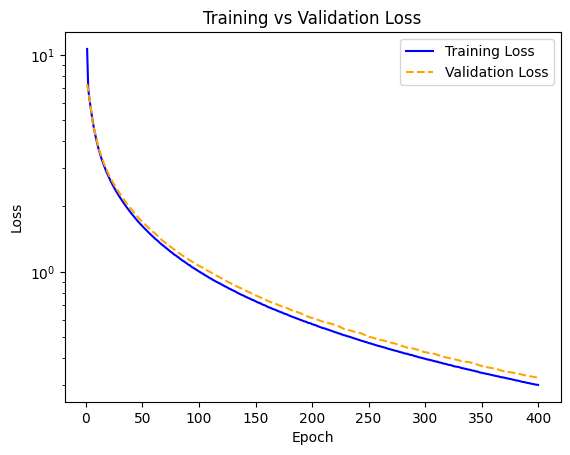

Train accuracy no validation = 93.89%
Test accuracy no validation = 61.74%
Train accuracy with validation = 93.85%
Test accuracy with validation = 61.17%


In [35]:
mlp = MLP(hidden_layers=[], activation_function='relu')
best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=0.01, epochs=400)
best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
plot_losses(train_losses, val_losses)
no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)

<h5> 1 hidden layer </h5>

In [ ]:
### ADD THE 1 LAYER GRID SEARCH FROM PREVIOUS ITTERATION OF CODE

From here on end, we try to confirm validity of GridSearch w/ our implementation

100%|██████████| 400/400 [04:50<00:00,  1.38it/s]


1 HIDDEN LAYER WITH 32 units and a 1.00 learning rate


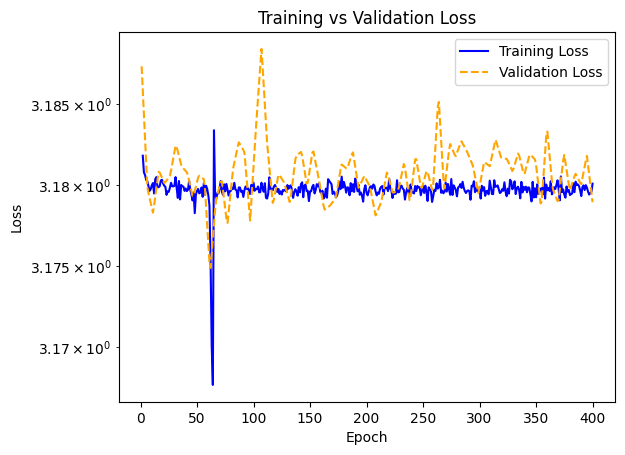

Train accuracy no validation = 4.37%
Test accuracy no validation = 3.43%
Train accuracy with validation = 5.04%
Test accuracy with validation = 2.01%







100%|██████████| 400/400 [04:53<00:00,  1.36it/s]


1 HIDDEN LAYER WITH 32 units and a 0.10 learning rate


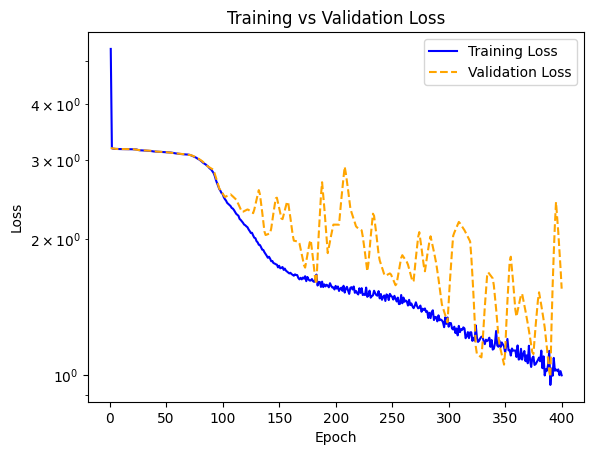

Train accuracy no validation = 43.94%
Test accuracy no validation = 28.82%
Train accuracy with validation = 65.29%
Test accuracy with validation = 41.94%







100%|██████████| 400/400 [05:06<00:00,  1.31it/s]


1 HIDDEN LAYER WITH 32 units and a 0.01 learning rate


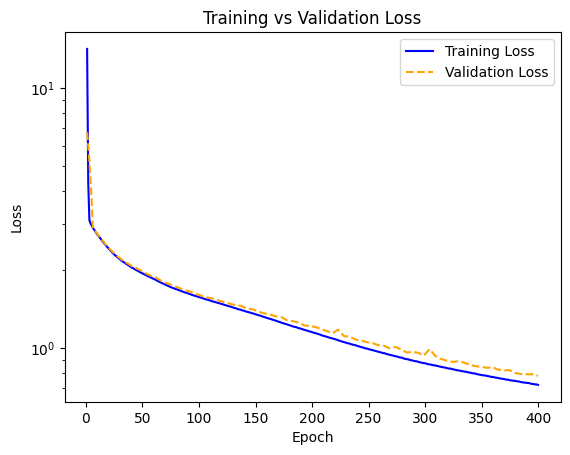

Train accuracy no validation = 76.21%
Test accuracy no validation = 48.15%
Train accuracy with validation = 75.97%
Test accuracy with validation = 48.45%







100%|██████████| 400/400 [04:58<00:00,  1.34it/s]


1 HIDDEN LAYER WITH 32 units and a 0.00 learning rate


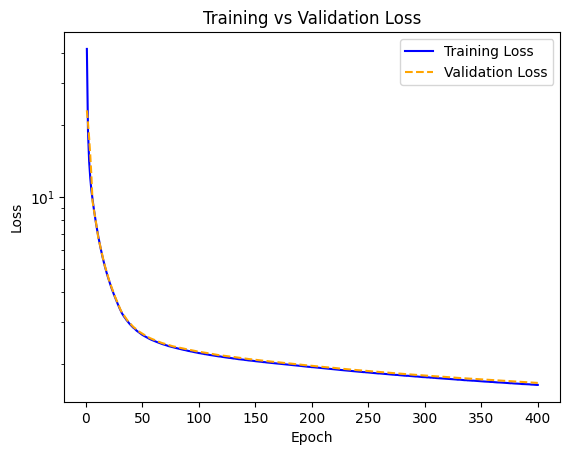

Train accuracy no validation = 47.14%
Test accuracy no validation = 42.93%
Train accuracy with validation = 46.92%
Test accuracy with validation = 42.97%







100%|██████████| 400/400 [06:46<00:00,  1.02s/it]


1 HIDDEN LAYER WITH 64 units and a 1.00 learning rate


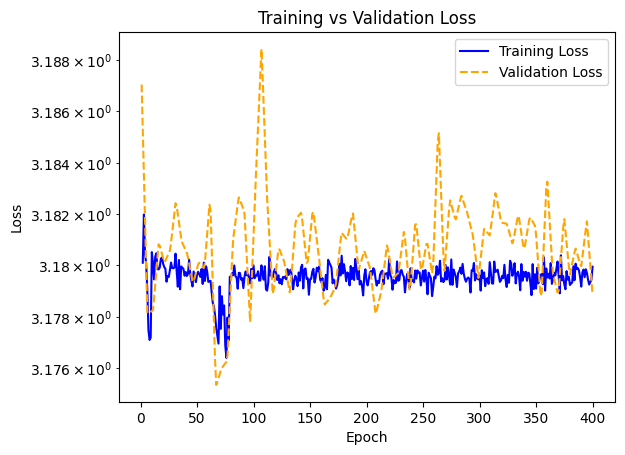

Train accuracy no validation = 4.37%
Test accuracy no validation = 3.43%
Train accuracy with validation = 4.44%
Test accuracy with validation = 3.44%







 45%|████▌     | 181/400 [02:59<03:32,  1.03it/s]

In [36]:
HIDDEN_UNITS = [32,64,128,256]
learning_rates = [1e0, 1e-1, 1e-2, 1e-3]
for i in HIDDEN_UNITS:
    for j in learning_rates:
        mlp = MLP(hidden_layers=[i], activation_function='relu')
        best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=j, epochs=400)
        best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
        print(f"1 HIDDEN LAYER WITH {i} units and a {j:.2f} learning rate")
        plot_losses(train_losses, val_losses)
        no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
        print("\n\n\n\n")

<h5> 2 hidden layer </h5>

In [ ]:
### ADD THE 2 LAYER GRID SEARCH FROM PREVIOUS ITTERATION OF CODE

In [ ]:
### HAVE TO DECIDE WHAT TO PUT HERE

<h3> 3.2 </h3>

In [ ]:
HIDDEN_UNITS = 0 #TBD
rate = 0 #TBD
activation_functions = ['relu', 'sigmoid', 'leakyRelu']
for act in activation_functions:
        mlp = MLP(hidden_layers=[i], activation_function=act)
        best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=rate, epochs=400)
        best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
        print(f"2 HIDDEN LAYER WITH {HIDDEN_UNITS} units and a {rate} learning rate for activation funtion {act}")
        plot_losses(train_losses, val_losses)
        no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
        print("\n\n\n\n")

<h3> 3.3 </h3>

In [ ]:
HIDDEN_UNITS = 0 #TBD
rate = 0 #TBD
regularization = [0.01, 0.05, 0.1, 0.5, 1, 1.5, 10]
for lam in regularization:
        mlp = MLP(hidden_layers=[HIDDEN_UNITS], activation_function='relu')
        best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=rate, epochs=400)
        best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
        print(f"2 HIDDEN LAYER WITH {HIDDEN_UNITS} units and a {rate} learning rate with L2 reg of {lam}")
        plot_losses(train_losses, val_losses)
        no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
        print("\n\n\n\n")

<h4> 3.4 </h4>

Using existing libraries such as Keras/TensorFlow or PyTorch, create a Convolutional
Neural Network (ConvNet) with 3 convolutional and 2 fully connected layers. You are free
in your choice of the hyperparameters of the convolutional layers. Experiment again with
using {32,64,128,256} hidden units in the fully connected layers and choose the best one.
Also, set the activations in all of the layers to be ReLU. Train this ConvNet on the Sign
Language MNIST dataset. Does using a ConvNet increase/decrease the accuracy compared to using MLPs? Provide comments on your results.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, number_of_hidden_units):
        super(ConvNet, self).__init__()

        #convolution -> input image is 28x28x1 (Width x Depth x Channels)
        #output dimensions = (xh + 2ph - fh + 1) x (xw + 2pw - fw +1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) #output -> (28 + 2*1 - 3 + 1) = 28x28x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) #output -> 28x28x64
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) #output -> 28x28x128

        #At this point if we flatten the image to vector representation for the linear layer, our input dimension would be 28*28*128=100,352 which is insanely large
        #We can apply max pooling, but we haven't really seen it in class I don't think unless I'm just behind on lectures
        #Its really quite simple, and because of the autograd provided by pytorch we don't have to think too hard about the math

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #Applying this effectively halves both the width and the height -> a 2x2 square in the orginal image is pooled to only the maximum value so 2x2 becomes 1. Stride of two allows this to never overlap

        #if we anticipate applying max pooling after conv1 then that yields 14x14x32
        #if we apply it after conv2 then that yields 7x7x64
        #So our input to the linear fully connected layers is 7x7x128 (after convolution 3) -> 128 separate 7x7 images (Feature maps)
        self.fc1 = nn.Linear(128*7*7, number_of_hidden_units)
        self.fc2 = nn.Linear(number_of_hidden_units, 25) #25 output units as previous (25 classes->really only 24 because there's a 0 examples of J and z is just chopped off the end)
    
    def forward(self, x, apply_softmax = False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x= self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)

        #Now we need to flatten the image to a vector representation
        x = x.view(-1, 7*7*128) #-1 allows pytorch to infer the size (batch dimension), 7x7x128 is as discussed above

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        if apply_softmax: #We only apply softmax if we need to, nn.CrossEntropyLoss does this internally for efficiency. So we will call forward(x, True) when we want probabilities instead of logits
            x = F.softmax(x, dim=1)

        return x

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

val_size = int(len(X_train_tensor)*0.2) #80:20 split
train_size = len(X_train_tensor)-val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

number_of_hidden_units_TORCH = 64 #To change


In [ ]:
import torch.optim as optim

conv_net = ConvNet(number_of_hidden_units=number_of_hidden_units_TORCH).float()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conv_net.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr = 0.001)

train_losses = []
val_losses = []

num_epochs = 300
for epoch in range(num_epochs):

    conv_net.train()
    train_loss = 0.0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = conv_net(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    conv_net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = conv_net(images)
            loss = loss_function(outputs, labels)
            val_loss+=loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# We can save the model parameters as a .pth file
model_path = 'conv_net_params.pth'
torch.save(conv_net.state_dict(), model_path)

plot_losses(train_losses, val_losses)

In [ ]:
def get_accuracy_stats_TORCH(model : ConvNet, params_path, X_test:torch.tensor, y_test:torch.tensor, X_train:torch.tensor, y_train:torch.tensor):
    model.load_state_dict(torch.load(params_path))
    model.eval() #faster

    device = torch.device("cpu")
    model.to(device)
    X_test=X_test.to(device)
    y_test=y_test.to(device)
    X_train=X_train.to(device)
    y_train=y_train.to(device)

    with torch.no_grad():
        probabilities_test = model.forward(X_test, apply_softmax=True)
        test_accuracy = evaluate_accuracy(y_test.numpy(), probabilities_test.numpy())*100
        probabilities_train = model.forward(X_train, apply_softmax=True)
        train_accuracy = evaluate_accuracy(y_train.numpy(), probabilities_train.numpy())*100
    
    print(f"Train accuracy = {train_accuracy:.2f}%")
    print(f"Test accuracy = {test_accuracy:.2f}%")
    return train_accuracy, test_accuracy

In [ ]:
get_accuracy_stats_TORCH(conv_net, model_path, X_test_tensor, y_test_tensor, X_train_tensor, y_train_tensor)

### 3.1 Implementations with different weight initializations

In [ ]:
# Training the model with different weight initializations

initialization_methods = ['zeros', 'uniform', 'gaussian', 'xavier', 'kaiming']
test_accuracies = {}
train_accuracies = {}

for init_method in initialization_methods:
    mlp = MLP(hidden_layers=[128], initialization=init_method)
    mlp.fit(X_train, y_train, epochs=100, learning_rate=0.001)

    y_pred_test = mlp.predict(X_test)
    test_accuracy = evaluate_acc(y_test_labels, y_pred_test)
    test_accuracies[init_method] = test_accuracy

    y_pred_train = mlp.predict(X_train)
    train_accuracy = evaluate_acc(y_train_labels, y_pred_train)
    train_accuracies[init_method] = train_accuracy

In [ ]:
print("The train accuracies are: \n")
print(train_accuracies)
print("\n")
print("The test accuracies are: \n")
print(test_accuracies)

The train accuracies are: 

{'zeros': 0.1, 'uniform': 0.82485, 'gaussian': 0.7944166666666667, 'xavier': 0.87785, 'kaiming': 0.8828333333333334}


The test accuracies are: 

{'zeros': 0.1, 'uniform': 0.8077, 'gaussian': 0.7818, 'xavier': 0.8604, 'kaiming': 0.8624}


### 3.2 Implementations with different numbers of hidden layers

In [ ]:
# No Hidden Layer (Logistic Regression):
mlp_no_hidden = MLP(hidden_layers=[], activation_function='relu')
mlp_no_hidden.fit(X_train, y_train, epochs=10, learning_rate=0.001)

In [ ]:
# One Hidden Layer with 128 Units:
mlp_single_hidden = MLP(hidden_layers=[128], activation_function='relu')
mlp_single_hidden.fit(X_train, y_train, epochs=10, learning_rate=0.001)

In [ ]:
# Two Hidden Layers each with 128 Units:
mlp_double_hidden = MLP(hidden_layers=[128, 128], activation_function='relu')
mlp_double_hidden.fit(X_train, y_train, epochs=10, learning_rate=0.001)

In [ ]:
train_accuracy_no_hidden = evaluate_acc(y_train_labels, mlp_no_hidden.predict(X_train))
print(f"Train Accuracy (No Hidden Layer): {train_accuracy_no_hidden:.4f}")

train_accuracy_single_hidden = evaluate_acc(y_train_labels, mlp_single_hidden.predict(X_train))
print(f"Train Accuracy (Single Hidden Layer): {train_accuracy_single_hidden:.4f}")

train_accuracy_double_hidden = evaluate_acc(y_train_labels, mlp_double_hidden.predict(X_train))
print(f"Train Accuracy (Two Hidden Layers): {train_accuracy_double_hidden:.4f}")

Train Accuracy (No Hidden Layer): 0.5999
Train Accuracy (Single Hidden Layer): 0.7620
Train Accuracy (Two Hidden Layers): 0.7771


In [ ]:
test_accuracy_no_hidden = evaluate_acc(y_test_labels, mlp_no_hidden.predict(X_test))
print(f"Test Accuracy (No Hidden Layer): {test_accuracy_no_hidden:.4f}")

test_accuracy_single_hidden = evaluate_acc(y_test_labels, mlp_single_hidden.predict(X_test))
print(f"Test Accuracy (Single Hidden Layer): {test_accuracy_single_hidden:.4f}")

test_accuracy_double_hidden = evaluate_acc(y_test_labels, mlp_double_hidden.predict(X_test))
print(f"Test Accuracy (Two Hidden Layers): {test_accuracy_double_hidden:.4f}")

Test Accuracy (No Hidden Layer): 0.5898
Test Accuracy (Single Hidden Layer): 0.7511
Test Accuracy (Two Hidden Layers): 0.7622


We get expected results!  

**Non-linearity:**   
Enables Complex Representations: Without non-linear activation functions, no matter how many layers a neural network has, it would behave just like a single-layer perceptron because summing these layers would give another linear function. Non-linearities allow neural networks to approximate complex, non-linear functions.

Representation Power: They help the network in capturing non-linear patterns in the data. Most real-world data is non-linear in nature, so without these functions, it would be hard for the network to model such data effectively.

Increased Capacity: A deeper network has more parameters and, in theory, should be able to represent more complex functions. However, with increased capacity comes the risk of overfitting, especially if the amount of training data is limited.

### 3.3 Implementations with different activations

In [ ]:
activation_functions = ['relu', 'sigmoid', 'tanh']

test_accuracies = {}
train_accuracies = {}

for act_func in activation_functions:
    mlp = MLP(hidden_layers=[128, 128], activation_function=act_func)
    mlp.fit(X_train, y_train, learning_rate=0.001, epochs=100)

    y_pred_test = mlp.predict(X_test)
    test_accuracy = evaluate_acc(y_test_labels, y_pred_test)
    test_accuracies[act_func] = test_accuracy

    y_pred_train = mlp.predict(X_train)
    train_accuracy = evaluate_acc(y_train_labels, y_pred_train)
    train_accuracies[act_func] = train_accuracy

In [ ]:
for act_func, acc in train_accuracies.items():
    print(f"Train Accuracy with {act_func} activation: {acc:.4f}%")

print("\n+++++\n")

for act_func, acc in test_accuracies.items():
    print(f"Test Accuracy with {act_func} activation: {acc:.4f}%")

Train Accuracy with relu activation: 0.7844%
Train Accuracy with sigmoid activation: 0.7737%
Train Accuracy with tanh activation: 0.8042%

+++++

Test Accuracy with relu activation: 0.7640%
Test Accuracy with sigmoid activation: 0.7617%
Test Accuracy with tanh activation: 0.7904%


The one with tanh activation seems to have best performance, however, this method may have the risk of vanishing gradient.  

Sigmoid may be more popular in the output layer of binary classification problems.  

Although not perform as the best one in this experiment, ReLU is simple and computationally efficient, leading to faster convergence during training.

### 3.4 Implementations with L1 and L2 regularization

In [ ]:
# Without regularization
mlp_no_reg = MLP(hidden_layers=[128, 128], activation_function='relu')
mlp_no_reg.fit(X_train, y_train, learning_rate=0.001, epochs=100)


# With L1 regularization
mlp_l1 = MLP(hidden_layers=[128, 128], l1_lambda=0.001, activation_function='relu')
mlp_l1.fit(X_train, y_train, learning_rate=0.001, epochs=100)


# With L2 regularization
mlp_l2 = MLP(hidden_layers=[128, 128], l2_lambda=0.0001, activation_function='relu')
mlp_l2.fit(X_train, y_train, learning_rate=0.001, epochs=100)


In [ ]:
train_accuracy_no_reg = evaluate_acc(y_train_labels, mlp_no_reg.predict(X_train))
print(f"Train Accuracy without regularization: {train_accuracy_no_reg:.4f}")

train_accuracy_l1 = evaluate_acc(y_train_labels, mlp_l1.predict(X_train))
print(f"Train Accuracy with L1 regularization: {train_accuracy_l1:.4f}")

train_accuracy_l2 = evaluate_acc(y_train_labels, mlp_l2.predict(X_train))
print(f"Train Accuracy with L2 regularization: {train_accuracy_l2:.4f}")

Train Accuracy without regularization: 0.7477
Train Accuracy with L1 regularization: 0.7801
Train Accuracy with L2 regularization: 0.7726


In [ ]:
accuracy_no_reg = evaluate_acc(y_test_labels, mlp_no_reg.predict(X_test))
print(f"Test Accuracy without regularization: {accuracy_no_reg:.4f}")

accuracy_l1 = evaluate_acc(y_test_labels, mlp_l1.predict(X_test))
print(f"Test Accuracy with L1 regularization: {accuracy_l1:.4f}")

accuracy_l2 = evaluate_acc(y_test_labels, mlp_l2.predict(X_test))
print(f"Test Accuracy with L2 regularization: {accuracy_l2:.4f}")

Test Accuracy without regularization: 0.7304
Test Accuracy with L1 regularization: 0.7595
Test Accuracy with L2 regularization: 0.7537


Regularization indeed play a role in enhancing the performance of neural networks ensuring that they don't overfit to the training data, but may only yield a notable difference in performance when dealing with training data that has already been overfit.

### 3.5 Implementations with unnormalized training data

In [ ]:
# Load the Fashion MNIST dataset without normalization
fashion_trainset_unnorm = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
fashion_testset_unnorm = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

fashion_train_images_unnorm, fashion_train_labels_unnorm = flatten_data(fashion_trainset_unnorm)
fashion_test_images_unnorm, fashion_test_labels_unnorm = flatten_data(fashion_testset_unnorm)

fashion_train_images_unnorm = fashion_train_images_unnorm.reshape(-1, 28*28)
fashion_test_images_unnorm = fashion_test_images_unnorm.reshape(-1, 28*28)

# Convert torch tensors to numpy
X_train_unnorm = fashion_train_images_unnorm.numpy()
X_test_unnorm = fashion_test_images_unnorm.numpy()
y_train_labels_unnorm = fashion_train_labels_unnorm.numpy()
y_test_labels_unnorm = fashion_test_labels_unnorm.numpy()

# One-hot encoding of labels
y_train_unnorm = np.eye(10)[y_train_labels_unnorm]
y_test_unnorm = np.eye(10)[y_test_labels_unnorm]


In [ ]:
mlp_unnorm = MLP(hidden_layers=[128, 128], activation_function='relu')
mlp_unnorm.fit(X_train_unnorm, y_train_unnorm, learning_rate=0.001, epochs=10)

In [ ]:
train_accuracy_unnorm = evaluate_acc(y_train_labels_unnorm, mlp_unnorm.predict(X_train_unnorm))
print(f"Train Accuracy with unnormalized data: {train_accuracy_unnorm:.4f}")

test_accuracy_unnorm = evaluate_acc(y_test_labels_unnorm, mlp_unnorm.predict(X_test_unnorm))
print(f"Test Accuracy with unnormalized data: {test_accuracy_unnorm:.4f}")

Train Accuracy with unnormalized data: 0.7608
Test Accuracy with unnormalized data: 0.7466


Compared with the base case before, normalization on data indeed improve the training and test accuracies.

### 3.6 Comparison between CNN and MLP

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input size is 28x28 and after two 2x2 max pooling, size becomes 7x7
        self.fc2 = nn.Linear(128, 10)  # 10 classes in Fashion MNIST

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        return x


In [ ]:
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size)

fashion_test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform),
    batch_size=batch_size)


In [ ]:
# Initialize the network, criterion, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in fashion_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(fashion_train_loader)}")


Epoch [1/10] Loss: 1.4276181202570597
Epoch [2/10] Loss: 1.339306949965159
Epoch [3/10] Loss: 1.3072561707178751
Epoch [4/10] Loss: 1.2840055649439495
Epoch [5/10] Loss: 1.2631821408907573
Epoch [6/10] Loss: 1.2471844750404357
Epoch [7/10] Loss: 1.232602602895101
Epoch [8/10] Loss: 1.2228965511957803
Epoch [9/10] Loss: 1.216178232828776
Epoch [10/10] Loss: 1.2112728945096334


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
accuracy = evaluate(model, fashion_test_loader)
print(f"Test Accuracy: {accuracy:.4f}%")

Test Accuracy: 47.6500%


In [ ]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
mlp = MLP(hidden_layers=[128, 128], activation_function='relu')
mlp.fit(X_train, y_train, epochs=10, learning_rate=0.001)

In [ ]:
train_accuracy = evaluate_acc(y_train_labels, mlp.predict(X_train))
print(f"Train Accuracy: {train_accuracy:.4f}%")

test_accuracy = evaluate_acc(y_test_labels, mlp.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}%")

Train Accuracy: 0.7300%
Test Accuracy: 0.7101%


Comments written in the write-up report.